In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] =10, 7

In [2]:
df = pd.read_csv('./data/SeaPlaneTravel.csv')

In [3]:
df.columns = ['month', 'Passengers']

In [4]:
df.isnull().sum()

month         0
Passengers    0
dtype: int64

In [5]:
df.dtypes

month         object
Passengers     int64
dtype: object

In [6]:
df.dropna(inplace=True)

In [7]:
df['month'] = pd.to_datetime(df.month)

In [8]:
df = df.set_index(['month'])

In [9]:
df.head()

,Passengers
month,
2003-01-01,112
2003-02-01,118
2003-03-01,132
2003-04-01,129
2003-05-01,121


# 1. VISUALIZING THE TIME SERIES

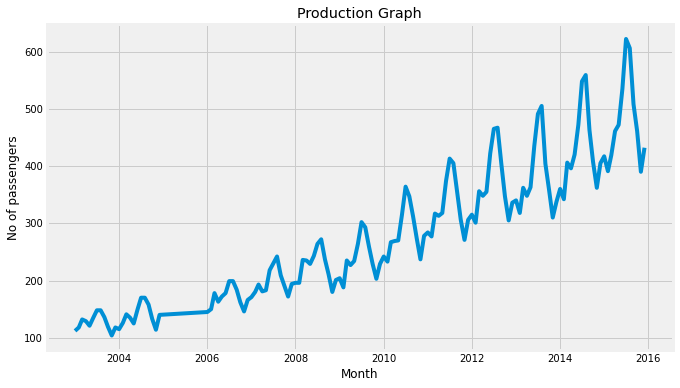

In [10]:
plt.figure(figsize=(10,6))
plt.xlabel('Month')
plt.ylabel('No of passengers')
plt.title('Production Graph')
plt.plot(df);

Remember that for time series forecasting, a series needs to be stationary. The series should have a constant mean, variance, and covariance.

There are few points to note here, the mean is not constant in this case as we can clearly see an upward trend.

Hence, we have identified that our series is not stationary. We need to have a stationary series to do time series forecasting. In the next stage, we will try to convert this into a stationary series.

### Let us plot a scatter plot

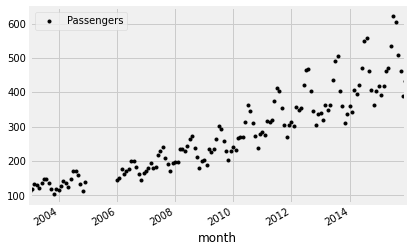

In [11]:
df.plot(style='k.')
plt.show();

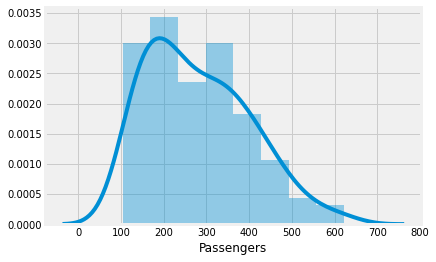

In [12]:
sns.distplot(df.Passengers);

We can observe a near-normal distribution(bell-curve) over consumption values.

Also, a given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

* Level: The average value in the series. 
* Trend: The increasing or decreasing value in the series.
* Seasonality: The repeating short-term cycle in the series.
* Noise: The random variation in the series.

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

# 2. Stationarising the time series.

First, we need to check if a series is stationary or not.

**ADF (Augmented Dickey-Fuller) Test**

**The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:**

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary (we will understand more about difference stationary in the next section).

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

The following function is one that can plot a series with its rolling mean and standard deviation.

In [13]:
from statsmodels.tsa.stattools import adfuller

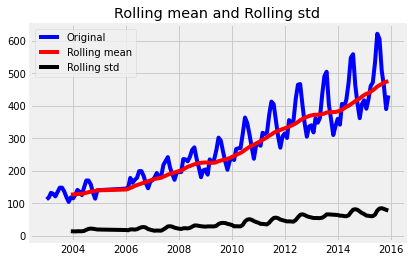

Results of Dickey-Fuller Test : 
Test statistics              0.815369
P-value                      0.991880
No of lags used             13.000000
no of observations used    130.000000
critical values (1%)        -3.481682
critical values (5%)        -2.884042
critical values (10%)       -2.578770
dtype: float64


In [14]:
def test_stationary(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    # plot rolling statistics
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling mean')
    plt.plot(rolstd, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean and Rolling std')
    plt.show(block=False)
    
    # Perform Dickey-Fuller Test
    print('Results of Dickey-Fuller Test : ')
    adft = adfuller(timeseries['Passengers'], autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4], index=['Test statistics', 'P-value', 'No of lags used', 'no of observations used'])
    for key,values in adft[4].items():
        output['critical values (%s)'%key] = values
    print(output)
test_stationary(df)

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

**To get a stationary series, we need to eliminate the trend and seasonality from the series.**

we start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

In [15]:
df_log = np.log(df)

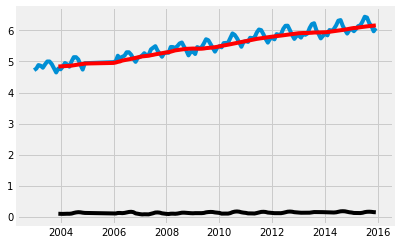

In [16]:
moving_avg = df_log.rolling(12).mean()
moving_std = df_log.rolling(12).std()
plt.plot(df_log)
plt.plot(moving_avg, color='red')
plt.plot(moving_std, color='black')
plt.show()

After finding the mean, we take the difference of the series and the mean at every point in the series.

This way, we eliminate trends out of a series and obtain a more stationary series.

In [17]:
df_log_moving_avg_diff = df_log - moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

Perform the Dickey-Fuller test (ADFT) once again. We have to perform this function every time to check whether the data is stationary or not.

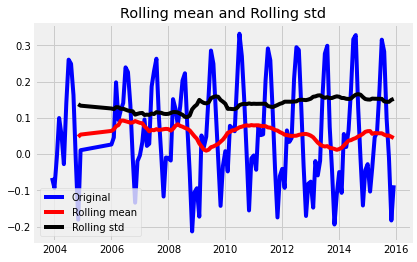

Results of Dickey-Fuller Test : 
Test statistics             -3.162908
P-value                      0.022235
No of lags used             13.000000
no of observations used    119.000000
critical values (1%)        -3.486535
critical values (5%)        -2.886151
critical values (10%)       -2.579896
dtype: float64


In [18]:
test_stationary(df_log_moving_avg_diff)

From the above graph, we observed that the data attained stationarity.

One of the modules is completed as we came to a conclusion. We need to check the weighted average, to understand the trend of the data in time series. Take the previous log data and to perform the following operation.

In [19]:
weighted_avg = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()

The exponential moving average (EMA) is a weighted average of the last n prices, where the weighting decreases exponentially with each previous price/period. In other words, the formula gives recent prices more weight than past prices.

**Previously we subtracted df_log with moving average, now take the same df_log and subtract with weighted_average and perform the Dickey-Fuller test (ADFT) once again.**

In [20]:
df_log_weighted_avg_diff = df_log - weighted_avg
df_log_weighted_avg_diff.dropna(inplace=True)

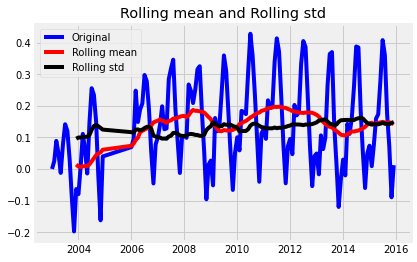

Results of Dickey-Fuller Test : 
Test statistics             -3.601262
P-value                      0.005737
No of lags used             13.000000
no of observations used    130.000000
critical values (1%)        -3.481682
critical values (5%)        -2.884042
critical values (10%)       -2.578770
dtype: float64


In [21]:
test_stationary(df_log_weighted_avg_diff)

From the above graph, we observed that the data attained stationarity. We also see that the test statistics and critical value is relatively equal.

There can be cases when there is a high seasonality in the data.

In those cases, just removing the trend will not help much. We need to also take care of the seasonality in the series. One such method for this task is differencing.

Differencing is a method of transforming a time series dataset.

It can be used to remove the series dependence on time, so-called temporal dependence. This includes structures like trends and seasonality. Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality.

Differencing is performed by subtracting the previous observation from the current observation.
Perform the Dickey-Fuller test (ADFT) once again.

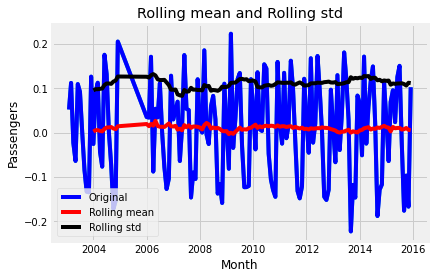

Results of Dickey-Fuller Test : 
Test statistics             -2.717131
P-value                      0.071121
No of lags used             14.000000
no of observations used    128.000000
critical values (1%)        -3.482501
critical values (5%)        -2.884398
critical values (10%)       -2.578960
dtype: float64


In [22]:
df_log_diff = df_log - df_log.shift()
plt.title('Shifted timeseries')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.plot(df_log_diff)
df_log_diff.dropna(inplace=True)
test_stationary(df_log_diff);

The next step is to perform decomposition which provides a structured way of thinking about a time series forecasting problem, both generally in terms of modeling complexity and specifically in terms of how to best capture each of these components in a given model. Finally, perform the Dickey-Fuller test (ADFT) once again.

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

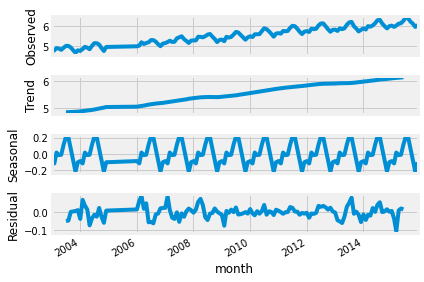

In [24]:
result = seasonal_decompose(df_log, model='additive', freq=12)
result.plot()
plt.show()

In [25]:
trend = result.trend
trend.dropna(inplace=True)
seasonality = result.seasonal
seasonality.dropna(inplace=True)
residual = result.resid
residual.dropna(inplace=True)

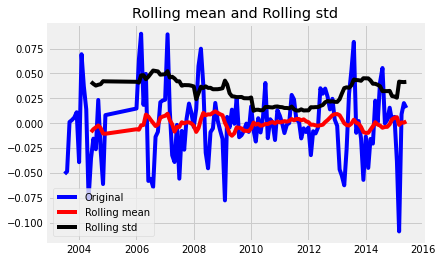

Results of Dickey-Fuller Test : 
Test statistics           -6.332387e+00
P-value                    2.885059e-08
No of lags used            9.000000e+00
no of observations used    1.220000e+02
critical values (1%)      -3.485122e+00
critical values (5%)      -2.885538e+00
critical values (10%)     -2.579569e+00
dtype: float64


In [26]:
test_stationary(residual)

After the decomposition, if we look at the residual then we have clearly a flat line for both mean and standard deviation. We have got our stationary series and now we can move to find the best parameters for our model.

# 3. Finding the best parameters for our model

Before we go on to build our forecasting model, we need to determine optimal parameters for our model. For those optimal parameters, we need ACF and PACF plots.

A nonseasonal ARIMA model is classified as an “ARIMA(p,d,q)” model, where:

p → Number of autoregressive terms,

d → Number of nonseasonal differences needed for stationarity, and

q → Number of lagged forecast errors in the prediction equation.

Values of p and q come through ACF and PACF plots. So let us understand both ACF and PACF!

## Autocorrelation Function(ACF)
 
Statistical correlation summarizes the strength of the relationship between two variables. Pearson’s correlation coefficient is a number between -1 and 1 that describes a negative or positive correlation respectively. A value of zero indicates no correlation.

We can calculate the correlation for time series observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a correlogram or an autocorrelation plot.

 

## Partial Autocorrelation Function(PACF)
 
A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

The autocorrelation for observation and observation at a prior time step is comprised of both the direct correlation and indirect correlations. It is these indirect correlations that the partial autocorrelation function seeks to remove.

**Below code plots, both ACF and PACF plots for us:**

In [27]:
from statsmodels.tsa.stattools import acf, pacf

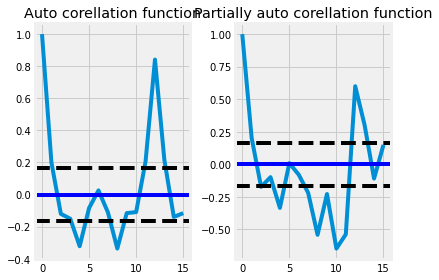

In [28]:
# we use d value here(data_log_shift)
acf = acf(df_log_diff, nlags=15)
pacf = pacf(df_log_diff, nlags=15, method='ols')
plt.subplot(121)
plt.plot(acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Auto corellation function')
plt.tight_layout()#plot ACF
plt.subplot(122)
plt.plot(pacf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

# 4. Fitting model

In order to find the p and q values from the above graphs, we need to check, where the graph cuts off the origin or drops to zero for the first time from the above graphs the p and q values are merely close to 3 where the graph cuts off the origin ( draw the line to x-axis) now we have p,d,q values. So now we can substitute in the ARIMA model and let's see the output.

In [29]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\Venu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Venu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


RSS : 0.983211


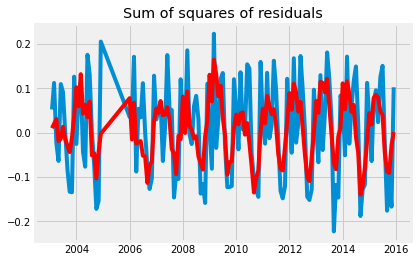

In [30]:
model = ARIMA(df_log, order=(3,1,3))
model_AR = model.fit(disp=0)
plt.plot(df_log_diff)
plt.plot(model_AR.fittedvalues, color='red')
plt.title('Sum of squares of residuals')
print('RSS : %f' %sum((model_AR.fittedvalues - df_log_diff['Passengers'])**2))

C:\Users\Venu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Venu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


RSS : 1.502303


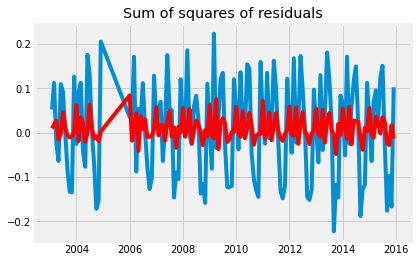

In [31]:
model = ARIMA(df_log, order=(2,1,0))
model_AR = model.fit(disp=0)
plt.plot(df_log_diff)
plt.plot(model_AR.fittedvalues, color='red')
plt.title('Sum of squares of residuals')
print('RSS : %f' %sum((model_AR.fittedvalues - df_log_diff['Passengers'])**2))

C:\Users\Venu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Venu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


RSS : 1.159556


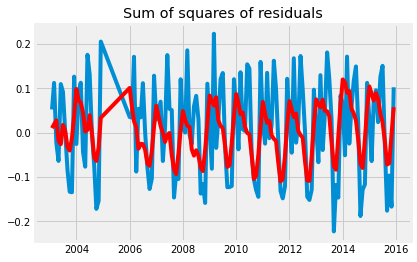

In [32]:
model = ARIMA(df_log, order=(3,1,1))
model_AR = model.fit(disp=0)
plt.plot(df_log_diff)
plt.plot(model_AR.fittedvalues, color='red')
plt.title('Sum of squares of residuals')
print('RSS : %f' %sum((model_AR.fittedvalues - df_log_diff['Passengers'])**2))

Less the RSS value, the more effective the model is when the smallest values of RSS.

# 5. Predictions

The following code helps us to forecast Air passenger sales for the next 6 years.

C:\Users\Venu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Venu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Venu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


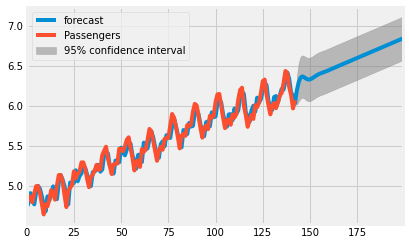

In [33]:
model_AR.plot_predict(1, 200)
x = model_AR.forecast(steps=200)

From the above graph, we calculated the future predictions in greyed out area is the confidence interval that means the predictions will not cross that area.